In [ ]:
!pip install wandb

In [ ]:
!pip install open-clip-torch

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [5]:
# from huggingface_hub import snapshot_download
# import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

# snapshot_download(repo_id="google/ddpm-celebahq-256", local_dir="./model", local_dir_use_symlinks=False)

In [6]:
model_id = r"G:\code\pretrain_model_dir\ddpm-celebahq-256"
image_pipe = DDPMPipeline.from_pretrained(model_id)
image_pipe.to(device);

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

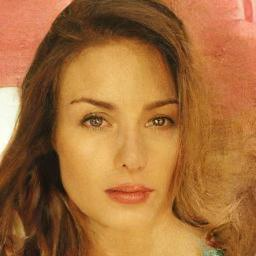

In [7]:
images = image_pipe().images
images[0]

# 使用新的调度器, 更快的采样速度

In [8]:
# 创建一个新的调度器并设置推理迭代次数
scheduler = DDIMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(num_inference_steps=40)

In [9]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

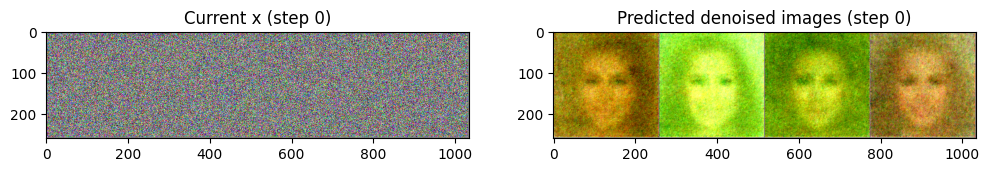

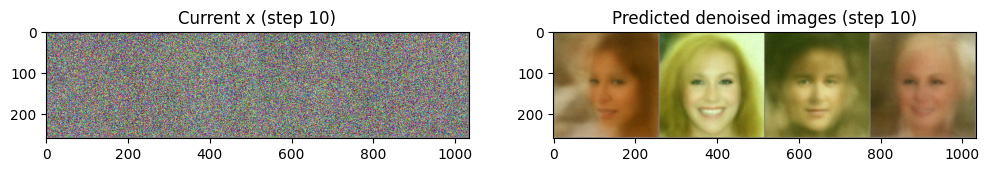

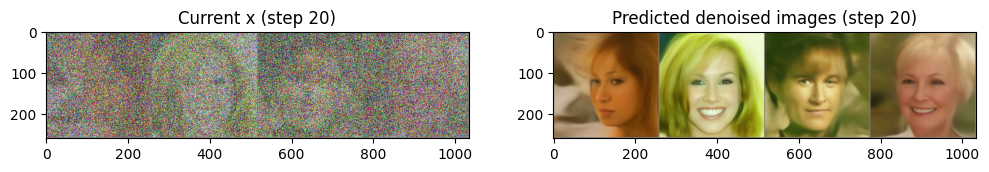

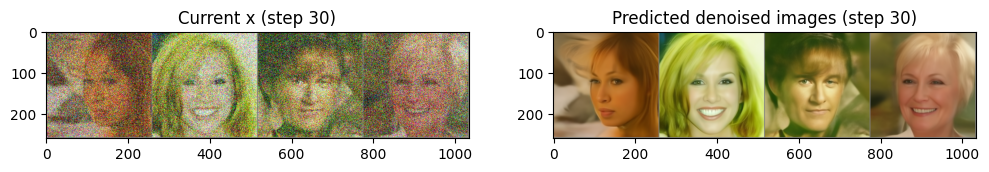

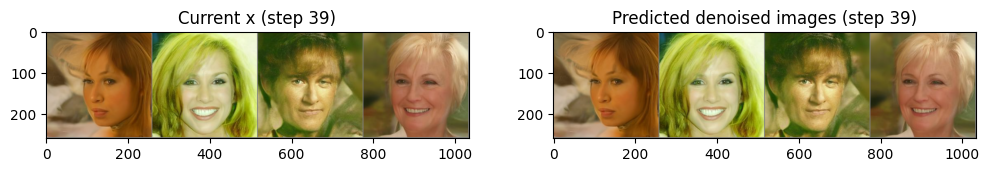

In [10]:
# 从随机噪声开始
x = torch.randn(4, 3, 256, 256).to(device)
# batch size为4，三通道，长、宽均为256像素的一组图像
# 循环一整套时间步
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 准备模型输入：给“带躁”图像加上时间步信息
    model_input = scheduler.scale_model_input(x, t)

    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 使用调度器计算更新后的样本应该是什么样子
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新输入图像
    x = scheduler_output.prev_sample

    # 时不时看一下输入图像和预测的“去噪”图像
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

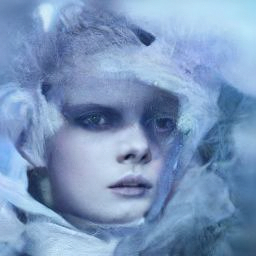

In [12]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

# 微调